<a href="https://colab.research.google.com/github/khaloodi/DS-Unit-2-Regression-2/blob/master/DS_Sprint_Challenge_8_Regression_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Regression 2 Sprint Challenge: Predict drugstore sales 🏥

For your Sprint Challenge, you'll use real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

You are given three dataframes:

- `train`: historical sales data for 100 stores
- `test`: historical sales data for 100 different stores
- `store`: supplemental information about the stores


The train and test set do _not_ have different date ranges. But they _do_ have different store ids. Your task is _not_ to forecast future sales from past sales. **Your task is to predict sales at unknown stores, from sales at known stores.**

In [0]:
import pandas as pd
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE')
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml')
store = pd.read_csv('https://drive.google.com/uc?export=download&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo')
assert train.shape == (78400, 7)
assert test.shape == (78400, 7)
assert store.shape == (200, 10)

The dataframes have a variety of columns:

- **Store** - a unique Id for each store
- **DayOfWeek** - integer, 1-6
- **Date** - the date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target you are predicting)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

This Sprint Challenge has three parts. To demonstrate mastery on each part, do all the required instructions. To earn a score of "3" for the part, also do the stretch goals.

## 1. Wrangle relational data, Log-transform the target
- Merge the `store` dataframe with the `train` and `test` dataframes. 
- Arrange the X matrix and y vector for the train and test sets.
- Log-transform the target for the train and test set.
- Plot the target's distribution for the train set, before and after the transformation.

#### Stretch goals
- Engineer 3+ more features.

In [0]:
store.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [0]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
1,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
2,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
3,11,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
4,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [0]:
train.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Promo',
       'SchoolHoliday'],
      dtype='object')

In [0]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday
0,4,5,2015-07-31,13995,1498,1,1
1,8,5,2015-07-31,8492,833,1,1
2,11,5,2015-07-31,10457,1236,1,1
3,12,5,2015-07-31,8959,962,1,1
4,34,5,2015-07-31,11144,1162,1,1


In [0]:
import numpy as np

In [0]:
X_train = train.copy()
X_test = test.copy()

feature = 'Sales'

X_train = X_train.merge(store, on='Store', how='left')
y_train = X_train[feature]
X_test = X_test.merge(store, on='Store', how='left')
y_test = X_test[feature]


In [0]:
X_train = X_train.drop(columns=feature)
X_test = X_test.drop(columns=feature)

### Log Transform

In [0]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_train)

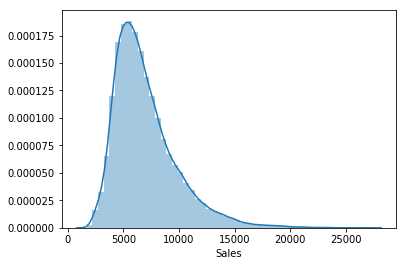

In [0]:
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

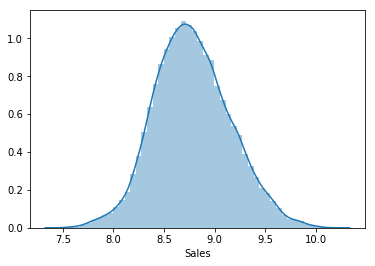

In [0]:
y_train_log = np.log1p(y_train)
sns.distplot(y_train_log);

## 2. Fit and validate your model
- **Use Gradient Boosting** or any type of regression model.
- **Beat the baseline:** The estimated baseline Root Mean Squared Logarithmic Error is 0.90, if we guessed the mean sales for every prediction. Remember that RMSE with the log-transformed target is equivalent to RMSLE with the original target. Try to get your error below 0.20.
- **To validate your model, choose any one of these options:**
  - Split the train dataframe into train and validation sets. Put all dates for a given store into the same set. Use xgboost `early_stopping_rounds` with the validation set. 
  - Or, use scikit-learn `cross_val_score`. Put all dates for a given store into the same fold.
  - Or, use scikit-learn `RandomizedSearchCV` for hyperparameter optimization. Put all dates for a given store into the same fold.
- **Get the Validation Error** (multiple times if you try multiple iterations) **and Test Error** (one time, at the end).
  
#### Stretch goal
- Optimize 3+ hyperparameters by searching 10+ "candidates" (possible combinations of hyperparameters). 

In [0]:
X_train.Date = pd.to_datetime(X_train.Date, infer_datetime_format=True)
X_train['date_year'] = X_train['Date'].dt.year
X_train['date_month'] = X_train['Date'].dt.month
X_train = X_train.drop(columns='Date')

In [0]:
X_test.Date = pd.to_datetime(X_test.Date, infer_datetime_format=True)
X_test['date_year'] = X_test['Date'].dt.year
X_test['date_month'] = X_test['Date'].dt.month
X_test = X_test.drop(columns='Date')

In [0]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

In [0]:
!pip install category_encoders

In [0]:
import category_encoders as ce
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

In [0]:
X_train.isna().sum()

Store                            0
DayOfWeek                        0
Customers                        0
Promo                            0
SchoolHoliday                    0
StoreType                        0
Assortment                       0
CompetitionDistance              0
CompetitionOpenSinceMonth    13328
CompetitionOpenSinceYear     13328
Promo2                           0
Promo2SinceWeek              62720
Promo2SinceYear              62720
PromoInterval                62720
date_year                        0
date_month                       0
dtype: int64

In [0]:
X_test.isna().sum()

Store                            0
DayOfWeek                        0
Customers                        0
Promo                            0
SchoolHoliday                    0
StoreType                        0
Assortment                       0
CompetitionDistance            784
CompetitionOpenSinceMonth    15680
CompetitionOpenSinceYear     15680
Promo2                           0
Promo2SinceWeek              65856
Promo2SinceYear              65856
PromoInterval                65856
date_year                        0
date_month                       0
dtype: int64

In [0]:
X_train.columns.tolist()

['Store',
 'DayOfWeek',
 'Customers',
 'Promo',
 'SchoolHoliday',
 'StoreType',
 'Assortment',
 'CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval',
 'date_year',
 'date_month']

In [0]:
drop = ['CompetitionDistance',
 'CompetitionOpenSinceMonth',
 'CompetitionOpenSinceYear',
 'Promo2SinceWeek',
 'Promo2SinceYear',
 'PromoInterval']

X_train = X_train.drop(columns=drop)
X_test = X_test.drop(columns=drop)

### Random Forest

In [0]:
# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1)
)

# Fit
pipeline.fit(X_train, y_train_log)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['StoreType', 'Assortment'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'StoreType',
                                          'data_type': dtype('O'),
                                          'mapping': c      1
a      2
d      3
NaN   -2
dtype: int64},
                                         {'col': 'Assortment',
                                          'data_type': dtype('O'),
                                          'mapping': c      1
a      2
NaN   -2
dtype: int64}],
                                return_df=True, verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                 

In [0]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Test
y_pred_log = pipeline.predict(X_train)
print('Validation Error', rmse(y_train_log, y_pred_log))

Validation Error 0.021955024330061308


### XGBoost

In [0]:
from xgboost import XGBRegressor
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)
eval_set = [(X_train_encoded, y_train_log), 
            (X_test_encoded, y_test_log)]
model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log, 
          eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=10)

[16:07:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:7.45973	validation_1-rmse:7.46005
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:6.71431	validation_1-rmse:6.71535
[2]	validation_0-rmse:6.04348	validation_1-rmse:6.04542
[3]	validation_0-rmse:5.43973	validation_1-rmse:5.44261
[4]	validation_0-rmse:4.8964	validation_1-rmse:4.90024
[5]	validation_0-rmse:4.40744	validation_1-rmse:4.413
[6]	validation_0-rmse:3.96741	validation_1-rmse:3.97571
[7]	validation_0-rmse:3.57144	validation_1-rmse:3.58191
[8]	validation_0-rmse:3.21513	validation_1-rmse:3.22843
[9]	validation_0-rmse:2.8945	validation_1-rmse:2.91084
[10]	validation_0-rmse:2.606	validation_1-rmse:2.62615
[11]	validation_0-rmse:2.34644	validation_1-rmse:2.37065
[12]	validation_0-rmse:2.11291	validation_1-rm

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

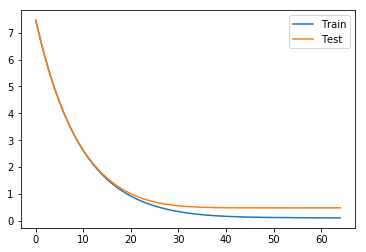

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

results = model.evals_result()
train_rmse = results['validation_0']['rmse']
test_rmse = results['validation_1']['rmse']
epoch = range(len(train_rmse))
plt.plot(epoch, train_rmse, label='Train')
plt.plot(epoch, test_rmse, label='Test')
plt.legend();

### Cross Val Score

In [0]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

model = XGBClassifier()
cross_val_score(model, X_train_encoded, y_train, 
                scoring='accuracy', cv=3, n_jobs=-1)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


TerminatedWorkerError: ignored

## 3. Plot model interpretation visualizations
- Choose any one of these options:
  - Permutation Importances plot
  - Partial Dependency Plot, 1 feature isolation
  - Partial Dependency Plot, 2 feature interaction
  
#### Stretch goals
- Plot 2+ visualizations.
- Use permutation importances for feature selection. 

### Feature Importances Using Random Forest

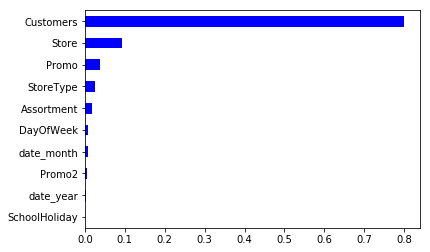

In [0]:
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='blue');

In [0]:
print('Shape before removing features:', X_train.shape)

Shape before removing features: (78400, 10)


In [0]:
!pip install pdpbox eli5

In [0]:
model = XGBRegressor(n_estimators=1000, n_jobs=-1)
model.fit(X_train_encoded, y_train_log)
y_pred_log = model.predict(X_test_encoded)

[16:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [0]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(model, scoring='neg_mean_squared_error', 
                                 cv='prefit', n_iter=2, random_state=42)

permuter.fit(X_train_encoded, y_train_log)
feature_names = X_train_encoded.columns.tolist()
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.2606 ± 0.0006,Customers
0.0302 ± 0.0003,Store
0.0082 ± 0.0001,Promo
0.0076 ± 0.0000,StoreType
0.0018 ± 0.0000,Assortment
0.0015 ± 0.0000,DayOfWeek
0.0013 ± 0.0000,Promo2
0.0012 ± 0.0000,date_month
0.0008 ± 0.0000,date_year
0.0001 ± 0.0000,SchoolHoliday


In [0]:
mask = permuter.feature_importances_ > 0
features = X_train.columns[mask]
X_train = X_train[features]
print('Shape after removing features:', X_train.shape)
X_test = X_test[features]

Shape after removing features: (78400, 10)


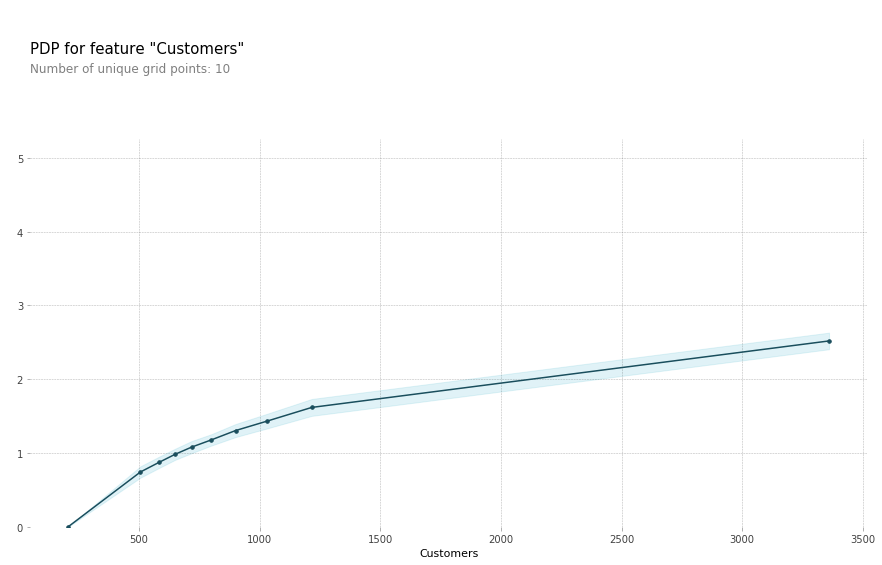

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Customers'

isolated = pdp_isolate(
    model=model, 
    dataset=X_train_encoded, 
    model_features=X_train_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

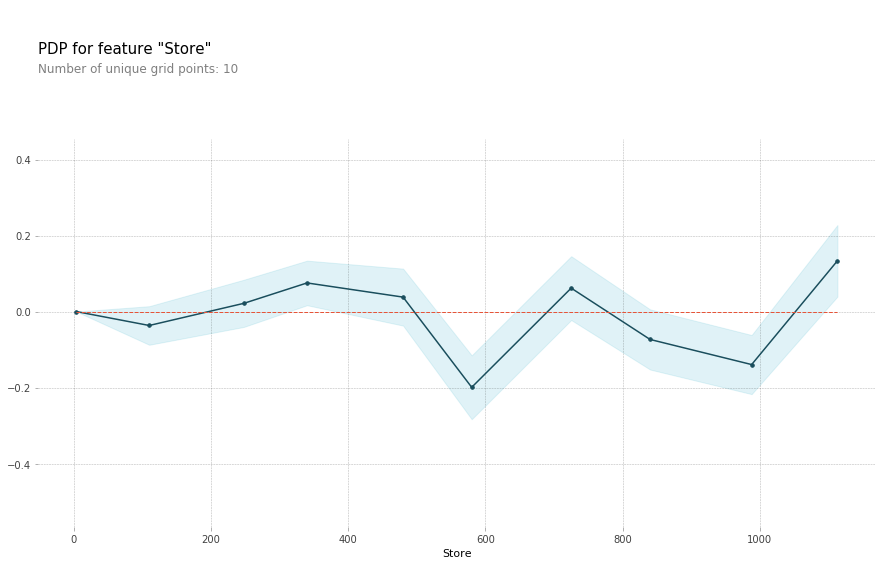

In [0]:
feature = 'Store'

isolated = pdp_isolate(
    model=model, 
    dataset=X_train_encoded, 
    model_features=X_train_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

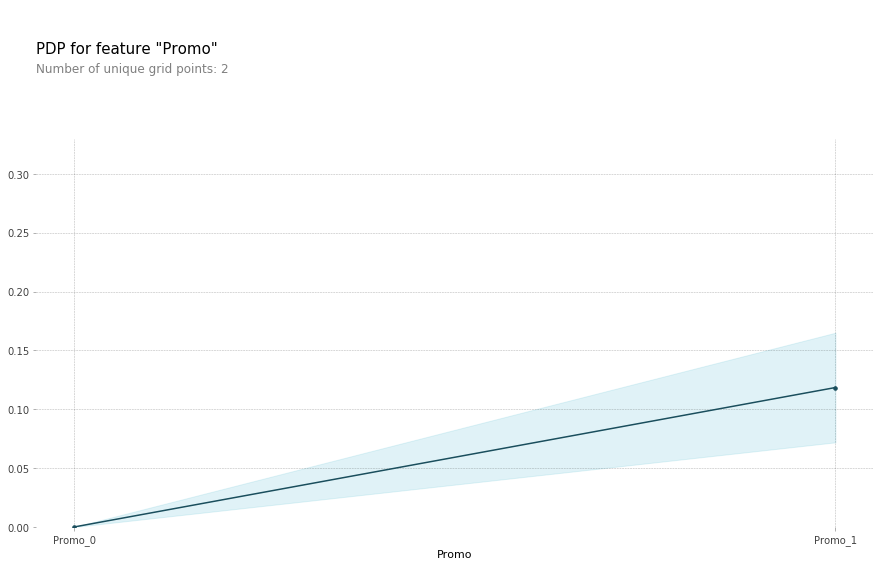

In [0]:
feature = 'Promo'

isolated = pdp_isolate(
    model=model, 
    dataset=X_train_encoded, 
    model_features=X_train_encoded.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);